# Cyclic hydration gravimetry and calorimetry
## data reduction and analysis for TGA/DSC/RH

### define global functions

In [1]:
def settle_clip(data, start_time=0):
        """ Function to clip datapoints from start of a scan """
        clip_data = np.delete(data, slice(start_time), axis=0)
        return clip_data


def c_pad(data, length, mode='edge'):
    """ Pad 'data' to 'length' by applying a buffer to either side
        if 'data' and 'length' are both even, buffer is symmetric
        if 'data' and 'length' are both odd, buffer is symmetric
        if 'data' and 'length' differ, an element of padding is removed
            default is to remove the last element of padding
        Args
            data (numpy array): numpy array to pad
            length (int): number of elements to pad on each side of `data`
    """
    
    lo = len(data)
    lb = length - lo

    if lb % 2 > 0: # odd total length
        data_pad = np.pad(data, lb // 2, mode=mode)[:-1]
    elif lb < 2: # if desired length is 1 or fewer extra elements, array is unchanged
        data_pad = data
        print('c_pad: Array not paddable. Desired length probably shorter than array itself. Keeping original length')
    else: # even total length
        data_pad = np.pad(data, lb // 2, mode=mode)

    return data_pad
    
    
def smooth(data, sm=0.01, pmode='edge'):
    """ Smooth data with a running-average convolution kernel after padding.
        Return array with original length.
        Args
            data (array): 1D data array to smooth
            sm (float, int): fraction of data to average over
            mode ('same', 'valid', 'full'): follows convention of numpy's `convolve`
            pmode (numpy `pad` convention): values to padd array with
    """

    data_len = len(data)
    kernel = int(sm * data_len) // 2
    
    if kernel % 2 > 0: kernel = kernel + 1
    if kernel <= 0: kernel = 1

    data_pad = c_pad(data, data_len + kernel, mode=pmode) # always even length
    samples = np.ones(kernel)/kernel # always even length
    corr = np.convolve(data_pad, samples, mode='valid')[1:] # size data_len - kernel + 1
    
    return corr


def normalize(data):
    """" normalize data by subtracting min and dividing by max """

    sign = np.sign(np.sum(data))

    if sign > 0:
        norm_data = (data - np.sign(np.max(data))*np.min(data)) / (np.max(data) - np.sign(np.min(data))*np.min(data))
    else:
        norm_data = sign*(data - np.sign(np.max(data))*np.max(data)) / (np.min(data) - np.sign(np.max(data))*np.max(data))

    return norm_data
    
    
def phase_corr_1d(data1, data2):
    """ find phase lag between two signals in the Fourier domain by normalized phase-correlation """

    pcorr = data1 * np.conj(data2)
    pcorr_norm = pcorr / np.abs(pcorr)
    pcorr_inv = np.fft.ifft(pcorr_norm)

    return pcorr_inv

### create CHGC class

In [2]:
#--- import libraries
    
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

plt.rcParams.update({'font.size': 20})

#--- define chgc class

class chgc():
    """ chgc is a class that analyzes cyclic hydration gravimetry and calorimetry data.
        the input to chgc is a raw text file of temperature, weight, relative humidity, and/or heat flow profiles.
            pre-processing is based on Mettler-Toledo TGA-DSC3+ output format
        
        methods:
        import_method - the temperature/relative humidity set points over time    
        parse_method -
        plot_method - 
        import_csv - 
    
    """
    #--- define chgc functions
    
    def __init__(self):
        # TGA/DSC3+ global variables
        self.samp_int = None # sampling rate
        self.samp_unit = None # s or min typically
        
        # TGA/DSC3+ method variables
        self.method = None
        self.method_data = None
        self.segs = []
        self.seg_num = []
        self.seg_loc = []
        self.start_segs = []
        self.end_segs = []
        
        # TGA/DSC3+ segment variables
        self.duration = []
        self.duration_unit = None # check for difference with samp_unit
        self.time = []
        self.seg_time = []
        self.rh_set = []
        self.rh_prof = []
        self.temperature_set = []
        self.temperature_prof = []
        
        # TGA/DSC3+ outputs
        self.data = None
        self.data_grad = None
        self.data_fft = None
        self.data_fft_power = None
        self.data_fft_phase = None
        
        # Analysis
        self.enthalpies = []
        self.cps = []
        self.cpr = []
        self.cp = []
        self.weight_water = []
        self.mole_water = []
        
    
    # --- define method functions ------------------------------------------
    def import_method(self, path):
        """ function to import the method file"""
        try: # try reading file
            codecs.open(path, encoding="utf-8", errors="ignore").readlines()
            self.method = open(path, encoding='utf-8').read()
        except UnicodeDecodeError: # if file can't be read, convert to utf-8
            with open(path, 'r', encoding='cp1252') as f:
                text = f.read()
            with open(path, 'w', encoding='utf-8') as f:
                f.write(text)
                self.method = open(path,encoding='utf-8').read()
    
    
    def parse_method(self):
        """ Parse a TGA/DSC method file into constituents for vizualization and analysis.
            Methods depict the temperature, relative humidity, and gas flow rate over a specified duration ...
                for a given number of segments
            Global variables are held constant over the course of an experiment
            Segment variables may change (or not) between segments
        """
        
        #--- search method document for segments, find location (element number) and number of segments 
        lines = self.method.split('\n')
        for i, line in enumerate(lines):
            if "sampling interval" in line.lower():
                self.samp_int = float(re.findall(r"\d+\.?\d*",line)[0])
                self.samp_unit = line.split(' ')[-1]
            
            if "segment" in line.lower():
                self.seg_loc.append(i)
                self.segs.append(line.split(' ')[-1])
                
            if "duration" in line.lower():
                self.duration.append(float(re.findall(r"\d+\.?\d*",line)[0]))
                self.duration_unit = line.split(' ')[-1]
                
            if "rel. humidity" in line.lower():
                self.rh_set.append([re.findall(r"\d+\.?\d*",line)[0]])
                
            if any(self.segs):
                if "temperature" in line.lower():
                    self.temperature_set.append([re.findall(r"\d+\.?\d*",line)[0]])
        
        #--- convert time units to seconds
        if self.duration_unit == self.samp_unit:
            pass
        elif self.samp_unit == 's':
            if self.duration_unit == 'min':
                self.duration = np.array(self.duration) * 60
        elif self.samp_unit == 'min': # not sure if this would happen
            if self.duration_unit == 's':
                self.duration = np.array(self.duration) / 60

        #--- make list of segment numbers for each datapoint, facilitating segmentwise operations
        self.seg_num = [float(num) * np.ones(int(float(dur) / self.samp_int)) for dur, num in zip(self.duration, self.segs)]
        self.seg_num = [int(t) for seg in self.seg_num for t in seg]
        self.seg_num = np.insert(self.seg_num, 0, 1)
                
        #--- put segment times into one list, and then take the cumulative sum for the running experiment time
        self.seg_time = [np.arange(self.samp_int, dur+1, self.samp_int)for dur in self.duration]
        self.seg_time[0] = np.insert(self.seg_time[0], 0, 0)
        
        self.time = [np.ones(int(float(dur) / self.samp_int)) for dur in self.duration] # this might break for different sample rates
        self.time = np.array([t for seg in self.time for t in seg])
        self.time = np.insert(np.cumsum(self.time), 0, 0)

        #--- find indeces corresponding to the end of each segment
        self.end_segs = np.array([len(seg) for seg in self.seg_time])
        self.end_segs[1:] += np.cumsum(self.end_segs[:-1]) - 1
        self.end_segs[0] = self.end_segs[0] - 1
        self.end_segs.astype(int) # recast as int for indexing
        
        #--- find indeces corresponding to the start of each segment
        self.start_segs = np.roll(self.end_segs, 1) + 1
        self.start_segs[0] = 0 # add first datapoint 
        self.start_segs.astype(int) # recast as int for indexing
        
        #--- make relative humidity profiles
        for seg, rh in zip(self.seg_time, self.rh_set):
            self.rh_prof.append(rh * len(seg))
        self.rh_prof = np.array([rh for seg in self.rh_prof for rh in seg]).astype('float64') #flatten
        
        #--- make temperature profiles
        for seg, t in zip(self.seg_time, self.temperature_set):
            self.temperature_prof.append(t * len(seg))
        self.temperature_prof = np.array([t for seg in self.temperature_prof for t in seg]).astype('float64') #flatten

    
    def plot_method(self, save=False, save_path=''):
        """ Plot the temperature and rh methods """
        
        fig, axs = plt.subplots(1,2, figsize=(22,6))
        plt.rcParams.update({'font.size': 20})

        axs[0].plot(self.time, self.rh_prof, color='b')
        axs[0].scatter(self.time[self.start_segs], self.rh_prof[self.start_segs], color='g', marker='o')
        axs[0].scatter(self.time[self.end_segs],   self.rh_prof[self.end_segs],   color='r', marker='o')
        axs[0].set_xlabel('time [min]')
        axs[0].set_ylabel('relative humidity [%]')
        

        axs[1].plot(self.time, self.temperature_prof, color='r')
        axs[1].scatter(self.time[self.start_segs], self.temperature_prof[self.start_segs], color='g', marker='o')
        axs[1].scatter(self.time[self.end_segs],   self.temperature_prof[self.end_segs],   color='r', marker='o')
        axs[1].set_xlabel('time [min]')
        axs[1].set_ylabel('reference temperature [$\degree$C]')

        plt.show
    
    
    #--- define data functions ------------------------------------------
    def import_csv(self, path, preprocess=False):
        """ function to import csv data from the specified path and convert to numpy array """
        if preprocess:
            skip_footer = 0
        else:
            skip_footer = 1
        
        self.data = np.genfromtxt(path, dtype=float, names=True, comments='[', skip_footer=skip_footer, encoding='cp1252') # data coming off Windows computer
        self.data_units = np.genfromtxt(path, dtype=str, names=True, autostrip=True, encoding='cp1252', skip_header=1, max_rows=1, deletechars='[]')
 
    
    def exclude_segments(self, segs=[1]):
        """ exclude segments from the data 
            Args
                segs (list): segment numbers to exclude. Default is [1], under the assumption that ...
                        you wouldn't call this method if you didn't want to remove at least one segment ...
                        and that the first one is the most likely to contain unwanted data
        """
        #--- preserve original data
        self.odata = self.data.copy()
        self.orh_prof = self.rh_prof.copy() 
        self.otemperature_prof = self.temperature_prof.copy()
        self.otime = self.time.copy()
        self.ostart_segs = self.start_segs.copy()
        self.oend_segs = self.start_segs.copy()
        self.oseg_num = self.seg_num.copy()
        
        #--- find indeces to remove
        ind_ex = np.in1d(np.array(self.seg_num), np.array(segs))
        ind_seg = np.in1d(np.array(self.segs).astype(int), np.array(segs))

        #--- remove indeces from data and profiles
        self.data = np.delete(self.data, ind_ex)
        self.rh_prof = np.delete(self.rh_prof, ind_ex)
        self.temperature_prof = np.delete(self.temperature_prof, ind_ex)
        self.time = np.delete(self.time, ind_ex)
        self.seg_num = np.delete(self.seg_num, ind_ex)
        
        self.segs = [seg for seg in self.segs if int(seg) not in segs]
        
    
    def data_gradient(self, sm=0.01, pmode='edge'):
        """ Take gradient of loaded data (temperature, weight, heat flow, rh, etc.).
            Data can be smoothed to reduce noise.
            Smoothing can be applied uniformly to every curve or individually to each curve.
            
            Args
                sm (list or float): fraction of data length over which to smooth
                smode ('same', 'valid', 'full'): smoothing mode, based on numpy `convolve` convention
                pmode ('edge', etc.): based on numpy `pad` convention
            
        """
        self.data_grad = self.data.copy() # create data_grad array with same size and headers as data
        d_cols = len(self.data.dtype.names) # number of data columns
        
        if type(sm)==list:
            assert len(sm) == d_cols , "smoothing list length must match data column length (" + str(d_cols) + ")"
            print("data columns are " + str(self.data.dtype.names))
        else: # list of smoothing fractions
            l = len(self.data.dtype.names)
            smo = sm * np.ones(l)
        
        for smoo, name in zip(smo, self.data.dtype.names):
            if name.lower() == 'index': # skip the index column to preserve proper indeces
                pass
            else:
                self.data_grad[name] = smooth(np.gradient(self.data_grad[name]), smoo, pmode=pmode) 
      
    
    def data_fouriertransform(self):
        """ Take Fourier Transform of loaded data (temperature, weight, heat flow, rh, etc.)
        """
        self.data_fft = self.data.copy() # create array with same size and headers as data
        self.data_fft_power = self.data.copy() # create array with same size and headers as data
        self.data_fft_phase = self.data.copy() # create array with same size and headers as data
       
        d_cols = len(self.data.dtype.names) # number of data columns
        d_type = list(zip(self.data.dtype.names, d_cols*['complex']))
        d_type_d = list(zip(self.data.dtype.names, d_cols*['float64']))
        
        self.data_fft = self.data_fft.astype(d_type)
        self.data_fft_power = self.data_fft_power.astype(d_type)
        
        for name in self.data.dtype.names:
            if name.lower() == 'index': # skip the index column to preserve proper indeces
                pass
            else:
                self.data_fft[name] = np.fft.fft(self.data_fft[name])
                self.data_fft_power[name] = np.abs(self.data_fft[name])**2
                self.data_fft_phase[name] = np.angle(self.data_fft[name])**2
        
        self.data_fft_power = self.data_fft_power.astype(d_type_d)
            
    
    def chgc_data(self, save=False, save_path=''):
        """ Plot the raw CHGC data in five panels:
                1. Reference temperature
                2. Sample temperature
                3. Weight
                4. Heat Flow
                5. Relative Humidity
        """

        fig, axs = plt.subplots(5, 1, figsize=(32, 32))
        plt.rcParams.update({'font.size': 20})

        axs[0].plot(self.data['t'], self.data['Tr'], color='b')
        axs[0].set_xlabel('time [s]')
        axs[0].set_ylabel(r'reference temperature [$\degree$C]')

        axs[1].plot(self.data['t'], self.data['Ts'], color='b')
        axs[1].set_xlabel('time [s]')
        axs[1].set_ylabel(r'sample temperature [$\degree$C]')

        axs[2].plot(self.data['t'], self.data['Weight'], color='k')
        axs[2].set_xlabel('time [s]')
        axs[2].set_ylabel(r'weight [mg]')

        axs[3].plot(self.data['t'], self.data['HF'], color='r')
        axs[3].set_xlabel('time [s]')
        axs[3].set_ylabel(r'heat flow [mW]')

        axs[4].plot(self.data['t'], self.data['RH'], color='g')
        axs[4].set_xlabel('time [s]')
        axs[4].set_ylabel(r'relative humidity [%]')
        axs[4].set_ylim([0,100])

        plt.show

        if save:
            plt.savefig(save_path)

    
    def chgc_grad_data(self, plot=True, save=False, save_path=''):
        """ Plot the raw CHGC data in five panels:
                1. Gradient of sample temperature
                2. Weight gradient
                3. Heat Flow
                4. Relative Humidity gradient
        """

        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(32, 28))
            plt.rcParams.update({'font.size': 20})

            axs[0].plot(self.data['t'], self.data_grad['Ts'], color='b')
            axs[0].set_xlabel(r'time [s]')
            axs[0].set_ylabel(r'$\partial$T/$\partial$t [$\degree$C / s]')

            axs[1].plot(self.data['t'], self.data_grad['Weight'], color='k')
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel(r'$\partial$weight/$\partial$t [mg/s]')

            axs[2].plot(self.data['t'], self.data_grad['HF'], color='r')
            axs[2].set_xlabel('time [s]')
            axs[2].set_ylabel(r'$\partial$heat flow/$\partial$t [mW/s]')

            axs[3].plot(self.data['t'], self.data_grad['RH'], color='g')
            axs[3].set_xlabel('time [s]')
            axs[3].set_ylabel(r'$\partial$RH/$\partial$t [%/s]')

            plt.show

        if save:
            plt.savefig(save_path)

    
    def chgc_fft_data(self, sm=0.01, pmode='constant', plot=True):
        """ function to plot the fft of the data
            Args
                sm (int): smoothing kernel to apply - fraction of total data length
                pmode = padding mode for smoothing kernel - takes convention from numpy `pad`
        """
        self.data_fft_time = np.arange(len(self.data_fft))
        self.data_fft_freq = np.fft.rfftfreq(len(self.data_fft)) / self.samp_int
        self.data_fft_freq_len = len(self.data_fft_freq)

        if self.data_fft_freq_len % 2 > 0:
            self.data_fft_freq_len = self.data_fft_freq_len - 1

        #--- shift fft for visualization
        self.data_fft_shift = self.data_fft[:self.data_fft_freq_len+1]
        self.data_fft_shift_power = self.data_fft_power[:self.data_fft_freq_len+1]
        
        #--- frequency of one method segment and its index in frequency list
        self.seg_freq = 1 / ((self.data_fft_freq_len) / float(max(chgc_test.segs)))
        idx = (np.abs(self.data_fft_freq - self.seg_freq)).argmin()
        
        if plot: # --- make plots

            fig, axs = plt.subplots(2, 2, figsize=(16, 16))
            plt.rcParams.update({'font.size': 20})

            ax = np.ndarray.flatten(axs)

            ax[0].plot(self.data_fft_freq, self.data_fft_shift_power['Ts'], color='k')
            ax[0].vlines(self.data_fft_freq[idx], 0, self.data_fft_shift_power['Ts'][idx], color='r', linestyle='dashed')
            ax[0].set_xlabel(r'frequency [$s^{-1}$]')
            ax[0].set_ylabel(r'power [dB]')
            ax[0].set_xscale('log')
            ax[0].set_yscale('log')
            ax[0].set_title('sample temperature')
            
            ax[1].plot(self.data_fft_freq, self.data_fft_shift_power['Weight'], color='k')
            ax[1].vlines(self.data_fft_freq[idx], 0, self.data_fft_shift_power['Weight'][idx], color='r', linestyle='dashed')
            ax[1].set_xlabel(r'frequency [$s^{-1}$]')
            ax[1].set_ylabel(r'power [dB]')
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
            ax[1].set_title('weight')
            
            ax[2].plot(self.data_fft_freq, self.data_fft_shift_power['HF'], color='k')
            ax[2].vlines(self.data_fft_freq[idx], 0, self.data_fft_shift_power['HF'][idx], color='r', linestyle='dashed')
            ax[2].set_xlabel(r'frequency [$s^{-1}$]')
            ax[2].set_ylabel(r'power [dB]')
            ax[2].set_xscale('log')
            ax[2].set_yscale('log')
            ax[2].set_title('heat flow')
            
            ax[3].plot(self.data_fft_freq, self.data_fft_shift_power['RH'], color='k')
            ax[3].vlines(self.data_fft_freq[idx], 0, self.data_fft_shift_power['RH'][idx], color='r', linestyle='dashed')
            ax[3].set_xlabel(r'frequency [$s^{-1}$]')
            ax[3].set_ylabel(r'power [dB]')
            ax[3].set_xscale('log')
            ax[3].set_yscale('log')
            ax[3].set_title('relative humidity')

            plt.show()
            
            
            #--- plot frequency window corresponding to one segment (assuming equal segment lengths)
            s = 1 # data sampling for visualization
            #self.data_fft_freq_smooth = smooth(self.data_fft_freq, sm)

            fig, axs = plt.subplots(2, 2, figsize=(16, 16))
            plt.rcParams.update({'font.size': 20})

            ax = np.ndarray.flatten(axs)

            ax[0].plot(smooth(self.data_fft_freq[idx::s], sm), smooth(self.data_fft_shift_power['Ts'][idx::s], sm), color='k')
            ax[0].set_xlabel(r'frequency [$s^{-1}$]')
            ax[0].set_ylabel(r'power [dB]')
            ax[0].set_xscale('log')
            ax[0].set_yscale('log')
            ax[0].set_title('sample temperature')
            
            ax[1].plot(smooth(self.data_fft_freq[idx::s], sm), smooth(self.data_fft_shift_power['Weight'][idx::s], sm), color='k')
            ax[1].set_xlabel(r'frequency [$s^{-1}$]')
            ax[1].set_ylabel(r'power [dB]')
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
            ax[1].set_title('weight')
            
            ax[2].plot(smooth(self.data_fft_freq[idx::s], sm), smooth(self.data_fft_shift_power['HF'][idx::s], sm), color='k')
            ax[2].set_xlabel(r'frequency [$s^{-1}$]')
            ax[2].set_ylabel(r'power [dB]')
            ax[2].set_xscale('log')
            ax[2].set_yscale('log')
            ax[2].set_title('heat flow')
            
            ax[3].plot(smooth(self.data_fft_freq[idx::s], sm), smooth(self.data_fft_shift_power['RH'][idx::s], sm), color='k')
            ax[3].set_xlabel(r'frequency [$s^{-1}$]')
            ax[3].set_ylabel(r'power [dB]')
            ax[3].set_xscale('log')
            ax[3].set_yscale('log')
            ax[3].set_title('relative humidity')
            
            plt.show()
            
    
    def rh_lag(self, plot=True):
        """ determine phase lag between RH change and heat flow
        """
        # take phase correlation, then determine whether shift is positive or negative
        # how much first is shifted relative to second
        corr = phase_corr_1d(self.data_fft['HF'], self.data_fft['RH'])
        corr_ny = len(corr) // 2
        corr_argmax = np.argmax(corr)
        
        # check for negative shift
        if corr_argmax > corr_ny:
            corr_argmax = int(corr_argmax - len(corr))
            
        self.rhlag_idx = corr_argmax
        self.rhlag = corr_argmax * self.samp_int
        
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            plt.rcParams.update({'font.size': 20})
            
            axs[0].plot(self.data['t'][:200], corr[:200], color='k')
            axs[0].set_title('positive shift')
            axs[0].set_ylim([10**-4, 10**0])
            axs[0].set_yscale('log')
            
            axs[1].plot(self.data['t'][-200:], corr[-200:], color='k')
            axs[1].set_title('negative shift')
            axs[1].set_ylim([10**-4, 10**0])
            axs[1].set_yscale('log')
            
            if self.rhlag_idx >= 0:
                axs[0].scatter(self.data['t'][self.rhlag_idx], corr[self.rhlag_idx], marker='o', s=128, color='r')
            else:
                axs[1].scatter(self.data['t'][self.rhlag_idx], corr[self.rhlag_idx], marker='o', s=128, color='r')
            
    
    def weight_lag(self, plot=True):
        """ determine phase lag between weight change and heat flow
        """
        # take phase correlation, then determine whether shift is positive or negative
        corr = phase_corr_1d(self.data_fft['Weight'], self.data_fft['HF'])
        corr_ny = len(corr) // 2
        corr_argmax = np.argmax(corr)
        
        #check for negative shift
        if corr_argmax > corr_ny:
            corr_argmax = int(corr_argmax - len(corr))
            
        self.weightlag_idx = corr_argmax
        self.weightlag = corr_argmax * self.samp_int
        
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            plt.rcParams.update({'font.size': 20})
            
            axs[0].plot(self.data['t'][:11000], corr[:11000], color='k')
            axs[0].set_title('positive shift')
            axs[0].set_ylim([10**-4, 10**0])
            axs[0].set_yscale('log')
            
            axs[1].plot(self.data['t'][-200:], corr[-200:], color='k')
            axs[1].set_title('negative shift')
            axs[1].set_ylim([10**-4, 10**0])
            axs[1].set_yscale('log')
            
            if self.weightlag_idx >= 0:
                axs[0].scatter(self.data['t'][self.weightlag_idx], corr[self.weightlag_idx], marker='o', s=128, color='r')
            else:
                axs[1].scatter(self.data['t'][self.weightlag_idx], corr[self.weightlag_idx], marker='o', s=128, color='r')
    

    def hydration_quant(data, start=1800, steps=21, plot=True):
        """ quantify hydration isotherms """

        m, md, mr = mass_steps(self.data['Weight'], start=start, steps=steps)
        rh = rh_steps(self.data['RH'], start=start, steps=steps)
        dQ, _ = hydration_integrate(data, plot=False)
        dH = (dQ * 17.998) / (md * 1000) # [kJ/mol]

        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))
            plt.rcParams.update({'font.size': 20})

            axs[0].plot(rh, mr, color='k')
            axs[0].scatter(rh, mr, color='k')
            axs[0].fill_between(rh[:11], mr[:11], np.flip(mr[10:]), color='k', alpha=0.2)
            axs[0].set_xlabel(r'$\Delta$RH [%]')
            axs[0].set_ylabel(r'$\Delta$m [%]')
            axs[0].set_xlim([0,100])

            axs[1].plot(rh[1:], np.abs(dH), color='k')
            axs[1].scatter(rh[1:], np.abs(dH), color='k')
            axs[1].set_xlabel(r'$\Delta$RH [%]')
            axs[1].set_ylabel(r'$\Delta H_{hyd}$ [kJ/mol]')
            axs[1].set_xlim([0,100])

            plt.show;

        return rh, mr, dH
    
    
    def hydration_integrate(self, plot=True):
        """ integrate heat flow curves in each segment to get hydration enthalpies 
        """
        self.hf_mean = np.mean(self.data['HF'])
        
        #--- plot settings
        if plot:
            fig, axs = plt.subplots(4, 2, figsize=(20, 24))
            plt.rcParams.update({'font.size': 20})
            ax = np.ndarray.flatten(axs)
            
            colors_hot = plt.cm.spring(np.linspace(0,1,len(self.segs)//2 + 1))
            colors_cool = plt.cm.cool(np.linspace(0,1,len(self.segs)//2 + 2))
            j, k = 0, 0 # plot increment counters for display
            
        #--- heat flow segments
        for i, seg in enumerate(self.segs):
            ind_ex = np.in1d(np.array(self.seg_num), int(seg))
            min_ind = np.min(np.argwhere(ind_ex))
            max_ind = np.max(np.argwhere(ind_ex))
            seg_time = np.arange(max_ind-min_ind)
            rh = self.rh_prof[min_ind]
            
            #--- heat flow normalize
            mean_float_hf = self.data['HF'][min_ind:max_ind] - self.hf_mean
            norm_hf = normalize(mean_float_hf)
            sign = np.sign(np.sum(norm_hf))
            total_hf = self.samp_int * np.cumsum(mean_float_hf) / 2
            
            # --- weight normalize
            weight = self.data['Weight'][min_ind:max_ind]
            norm_weight = (weight - np.min(weight)) / (np.max(weight) - np.min(weight))
            
            #--- enthalpy
            total_enthalpy = self.samp_int * np.cumsum(mean_float_hf) / (2 * weight)
            self.weight_water.append(np.max(weight) - np.min(weight))
            self.mole_water.append(self.weight_water[i] / (0.001 * 17.998)) # (g/mol H2O)
            
            #--- fit weight data to heat flow curve to approximate cp background
            s = 10 # number of datapoints to take from end of cumulative integral
            A = np.vstack([seg_time[-s:], np.ones(len(seg_time[-s:]))]).T
            total_hf_rate, total_hf_offset = np.linalg.lstsq(A, total_hf[-s:], rcond=None)[0]
            
            #--- fit background to heat flow and correct enthalpy
            enthalpy_bg_sub = mean_float_hf - total_hf_rate * norm_weight
            self.enthalpies.append((self.samp_int * np.sum(enthalpy_bg_sub) * 17.998) / (2 * 1000 * self.weight_water[i]))
            self.cps.append((self.samp_int * total_hf_rate * 1000 * len(mean_float_hf) * 17.998) / (2 * 1000 * self.weight_water[i] * (273+18)))
              
            # --- make plots
            if sign > 0:
                j += 1
                color = colors_hot[j]
            else:
                k += 1
                color = colors_cool[k]
            
            if plot:
                ax[0].plot(seg_time, mean_float_hf, color=color)
                ax[0].set_xlabel('time [s]')
                ax[0].set_ylabel(r'heat flow [mW]')
                ax[0].hlines(0, 0, np.max(seg_time), color='k')

                ax[1].plot(seg_time, smooth(norm_hf, sm=0.1), color=color)
                ax[1].set_xlabel('time [s]')
                ax[1].set_ylabel(r'normalized heat flow [mW]')
                ax[1].hlines(0, 0, np.max(seg_time),color='k')
                
                ax[2].plot(seg_time, total_hf, color=color)
                ax[2].set_xlabel('time [s]')
                ax[2].set_ylabel(r'total heat flow [mW]')
                ax[2].hlines(0, 0, np.max(seg_time), color='k')

                ax[3].plot(seg_time, total_enthalpy, color=color)
                ax[3].set_xlabel('time [s]')
                ax[3].set_ylabel(r'total  enthalpy [J/g-sample]')
                ax[3].hlines(0, 0, np.max(seg_time), color='k')
                
                ax[4].plot(seg_time, norm_weight, color=color)
                ax[4].set_xlabel('time [s]')
                ax[4].set_ylabel(r'weight fraction')
                ax[4].hlines(0, 0, np.max(seg_time), color='k')
                
                ax[5].scatter(self.mole_water[i], self.cps[i], color=color)
                ax[5].set_xlabel(r'$n$ $H_2O$')
                ax[5].set_ylabel(r'$C_p$ [J/K]')
                
                ax[6].scatter(rh, np.abs(self.enthalpies[i]), color=color)
                ax[6].set_xlabel(r'RH [%]')
                ax[6].set_ylabel(r'$\Delta$H [kJ/mol-water]')
                ax[6].set_ylim([0,20])
                
                ax[7].scatter(self.mole_water[i], self.enthalpies[i], color=color)
                ax[7].set_xlabel(r'$n$ $H_2O$')
                ax[7].set_ylabel(r'$\Delta$H [kJ/mol-water]')
        
        
        #--- fit trend to cp data
        mid = len(self.mole_water) // 2 + 1
        
        A = np.vstack([self.mole_water[1:mid], np.ones(len(self.mole_water[1:mid]))]).T
        cpr, cp = np.linalg.lstsq(A, self.cps[1:mid], rcond=None)[0]
        n = np.arange(0, int(np.max(self.mole_water)), 0.1)
        ax[5].plot(n, cpr*n + cp, color='k')

        self.cpr.append(cpr)
        self.cp.append(cp)
        
        A = np.vstack([self.mole_water[mid:], np.ones(len(self.mole_water[mid:]))]).T
        cpr, cp = np.linalg.lstsq(A, self.cps[mid:], rcond=None)[0]
        n = np.arange(0, int(np.max(self.mole_water)), 0.1)
        ax[5].plot(n, cpr*n + cp, color='k')
        
        self.cpr.append(cpr)
        self.cp.append(cp)
        
        plt.show()

In [3]:
chgc_test = chgc()

In [4]:
chgc_test.import_method('YT1_11A_Method.txt')

In [5]:
chgc_test.parse_method()

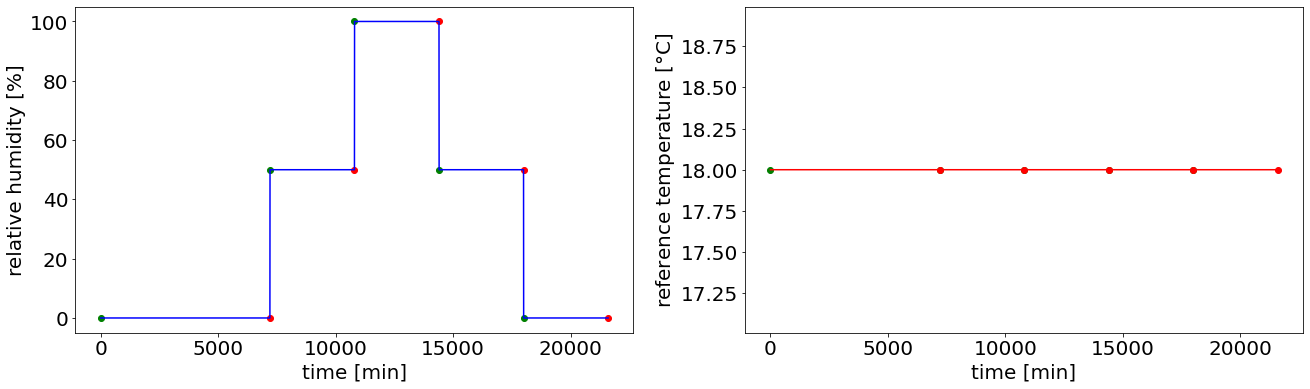

In [6]:
chgc_test.plot_method()

In [7]:
chgc_test.import_csv('YT1_11A.txt', preprocess=True)

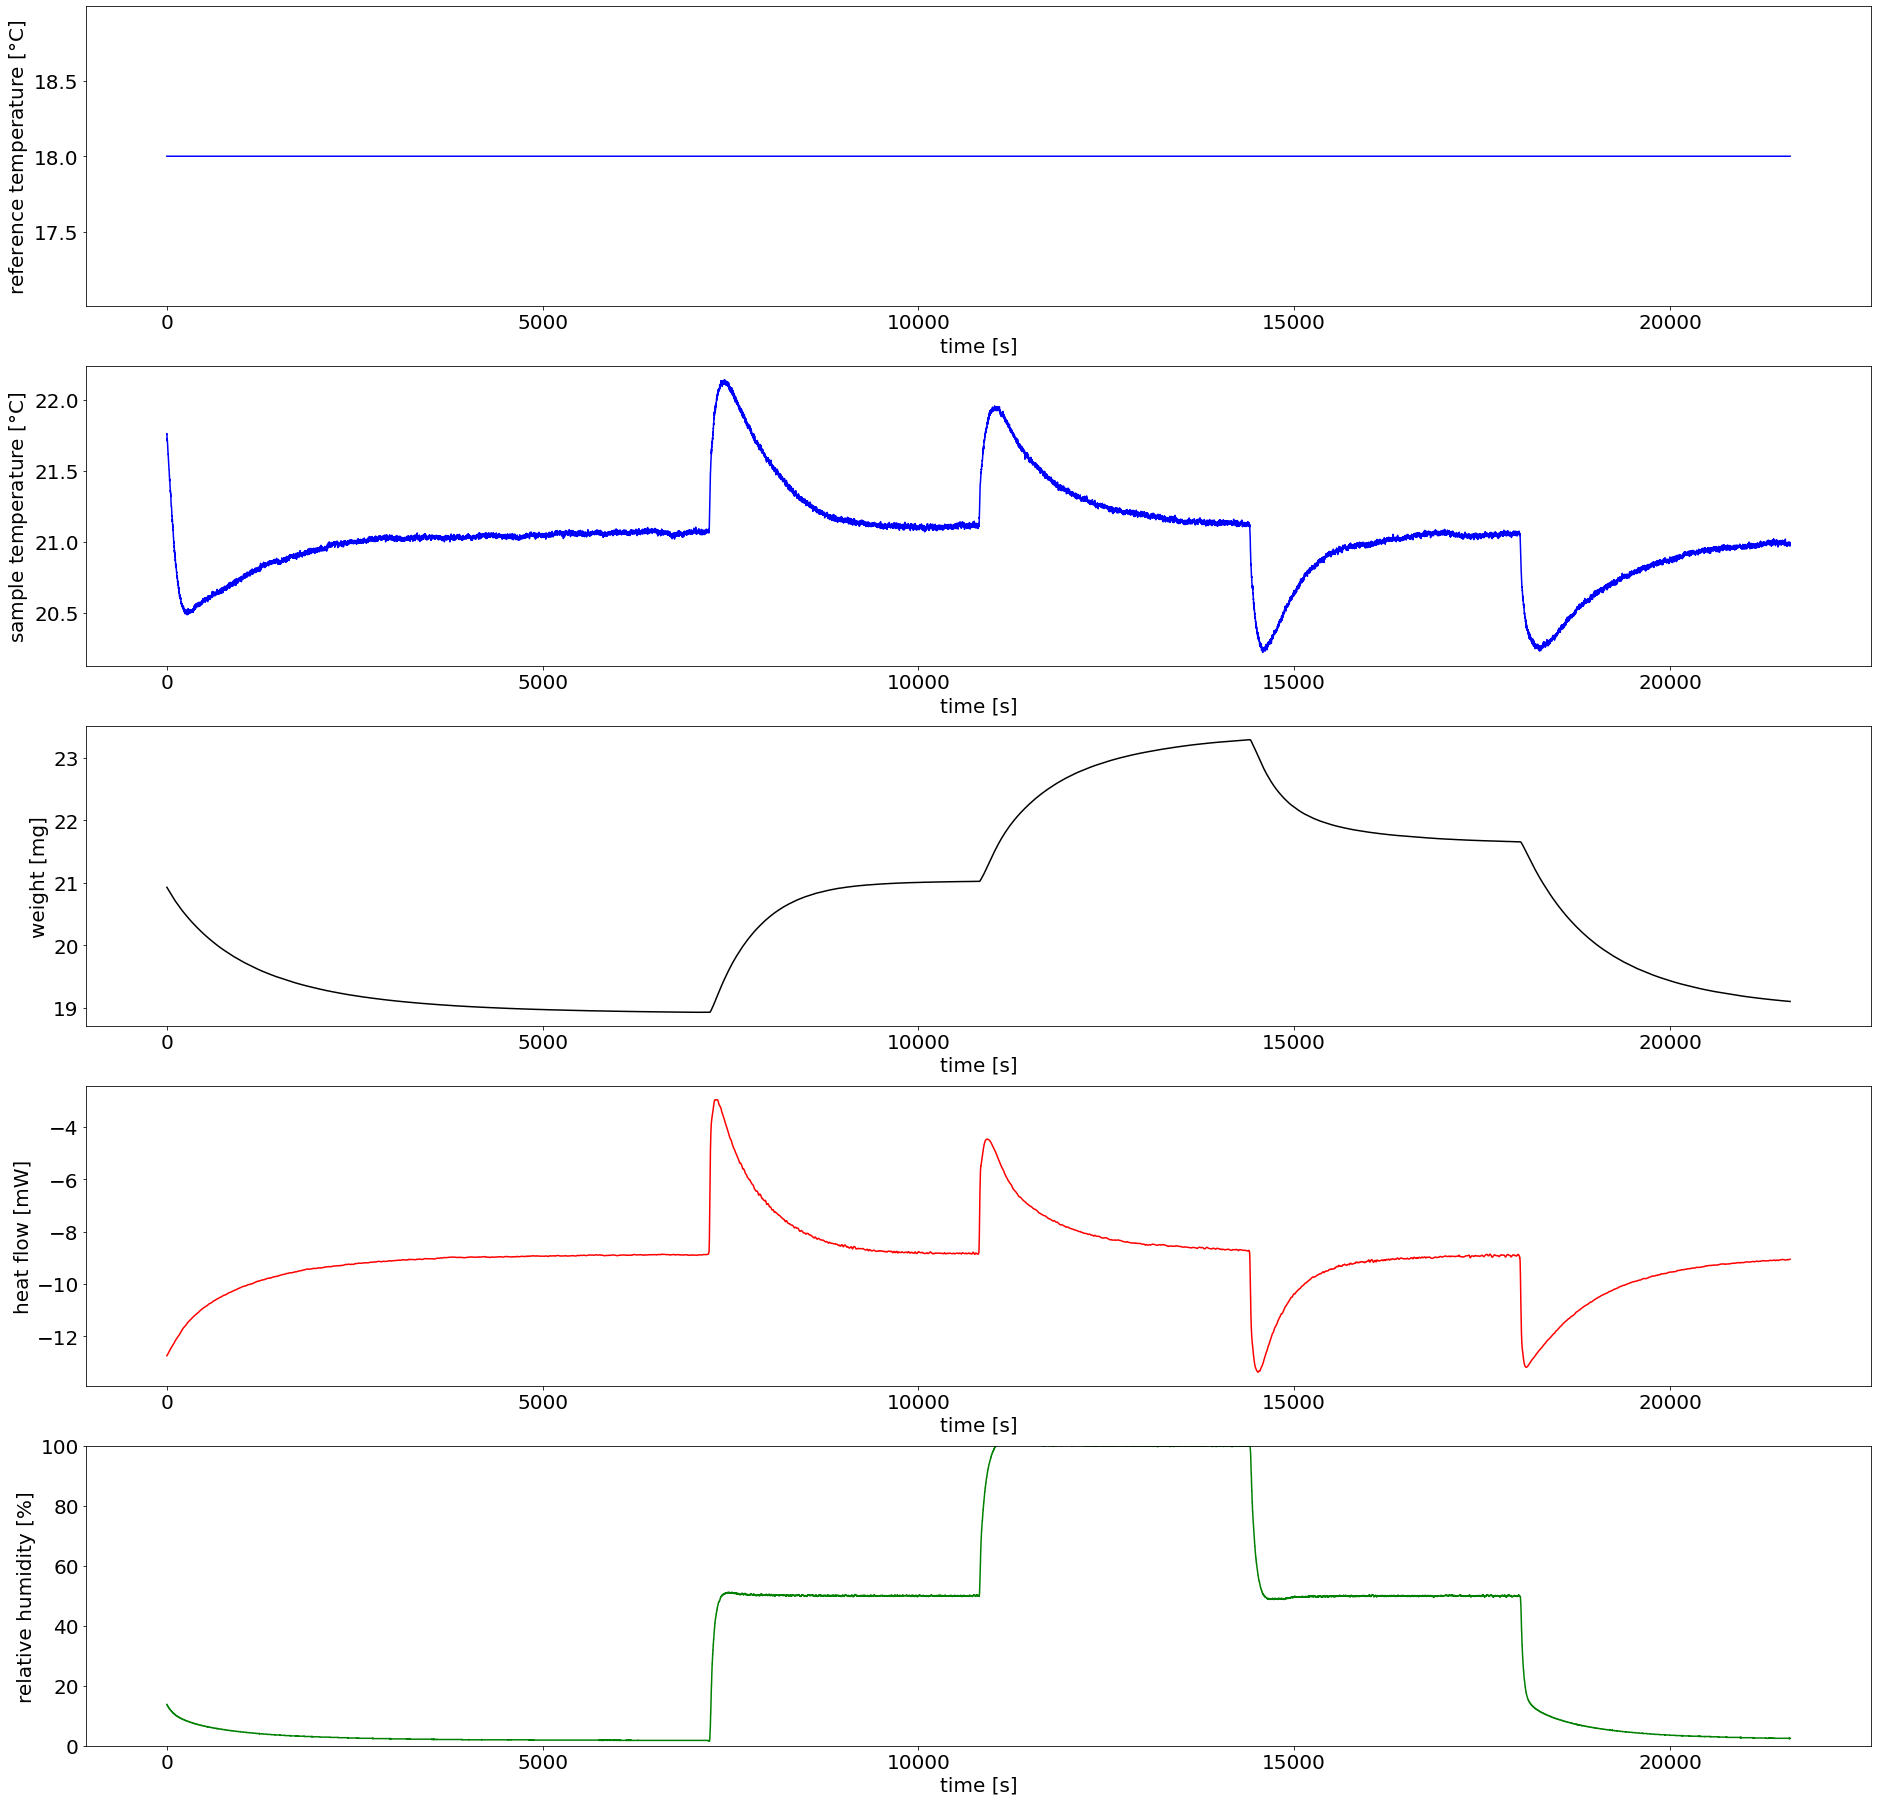

In [8]:
chgc_test.chgc_data()

In [9]:
chgc_test.data_gradient()

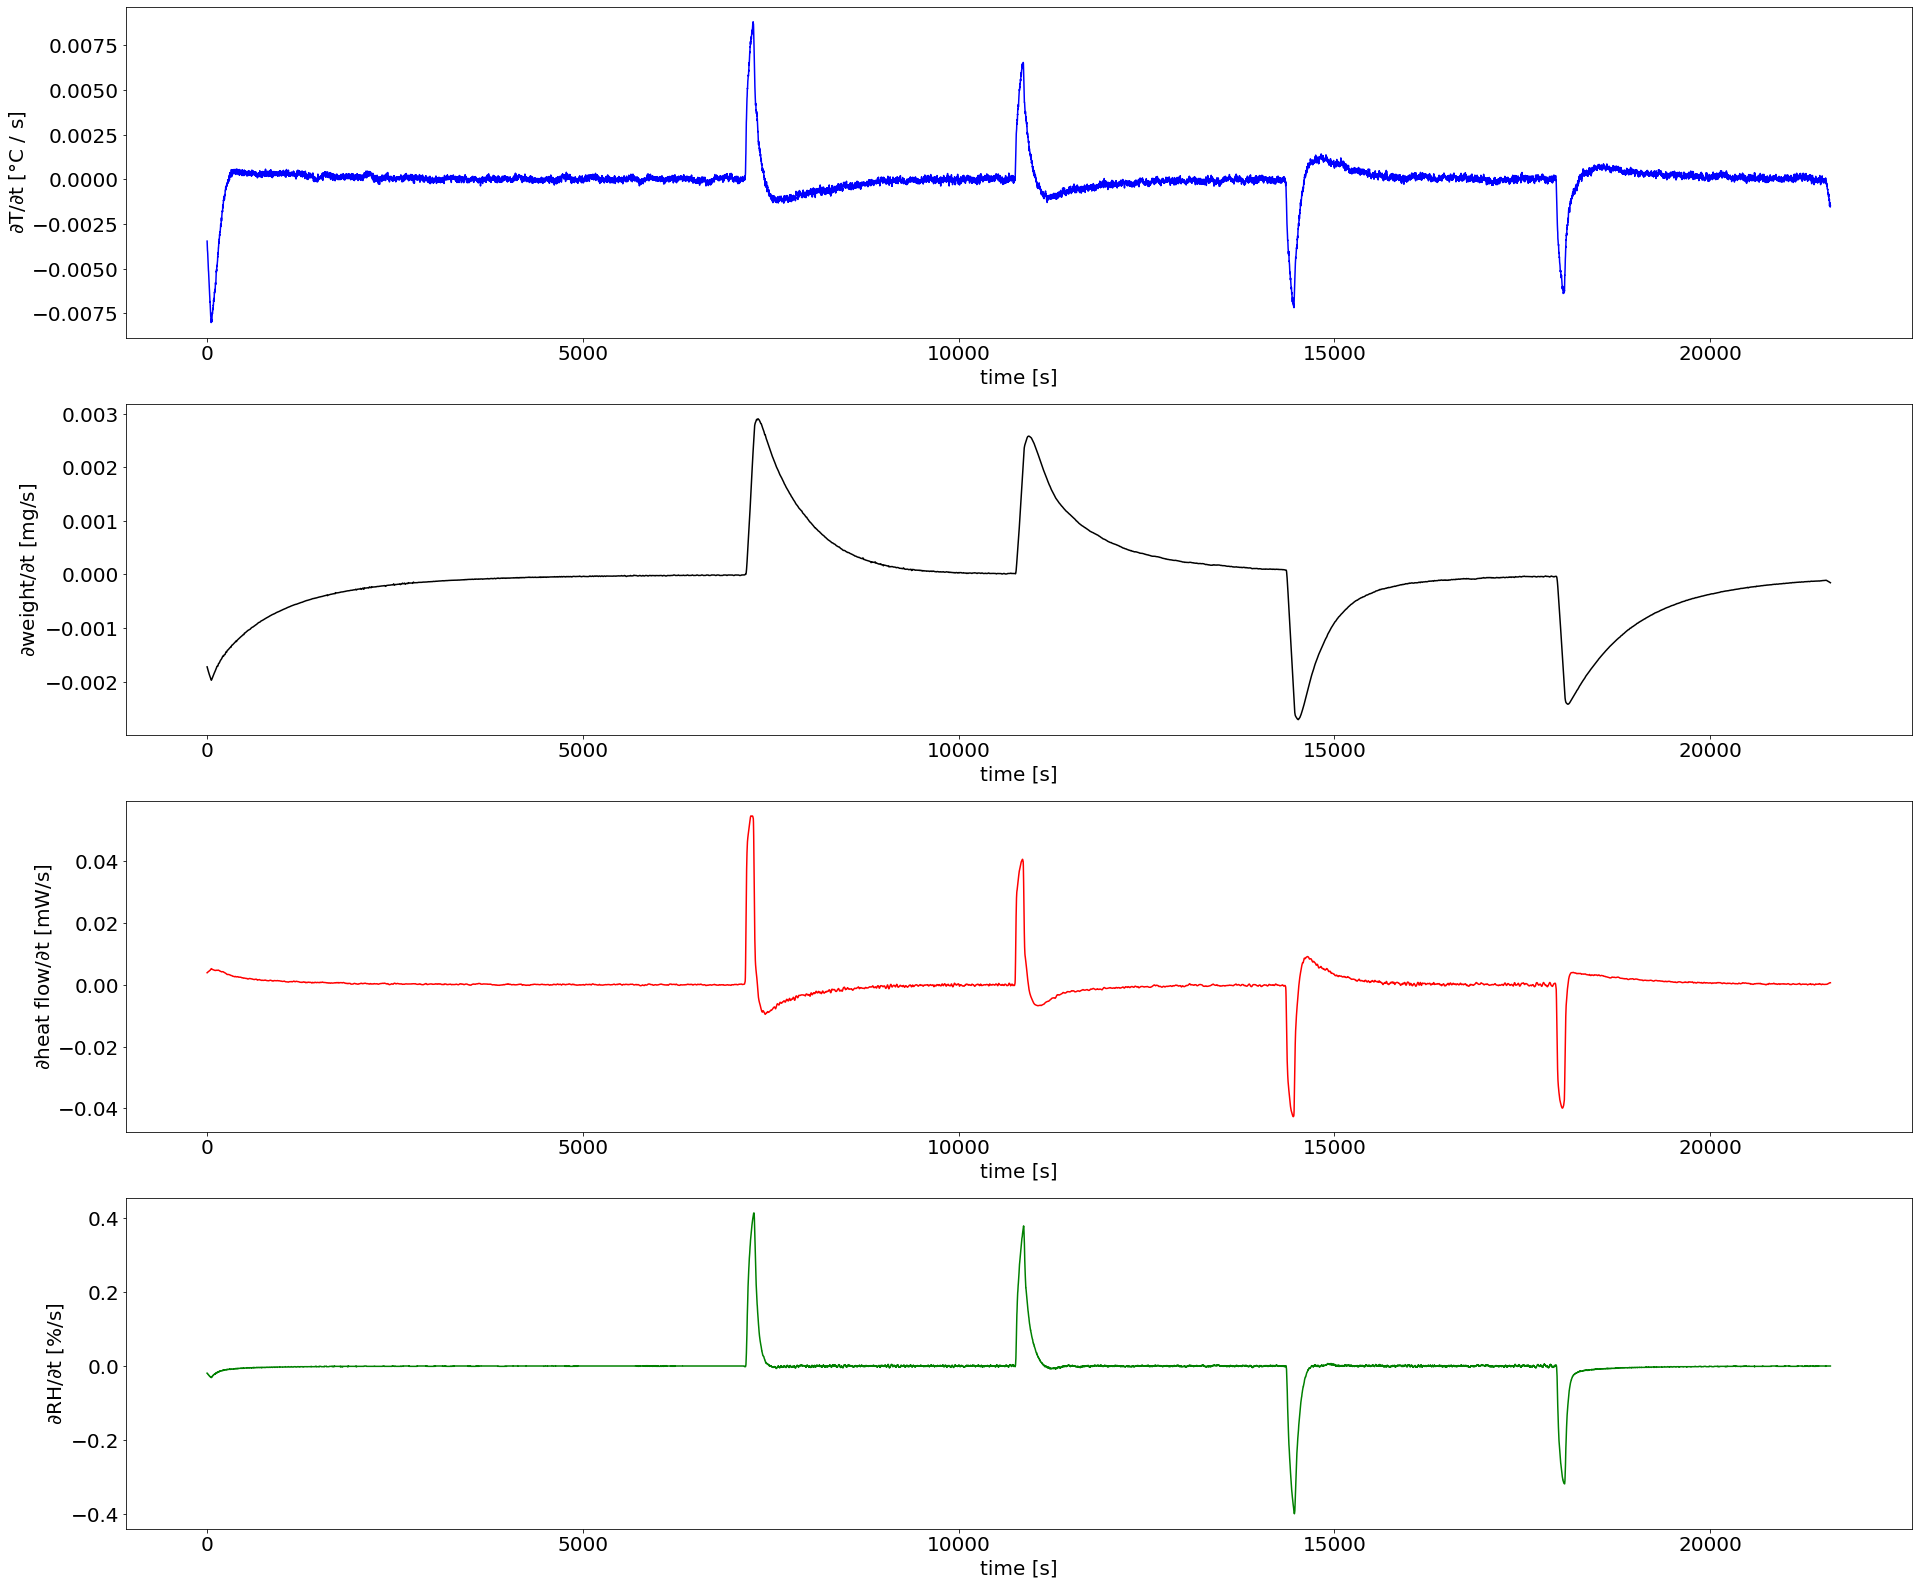

In [10]:
chgc_test.chgc_grad_data()

In [11]:
chgc_test.exclude_segments()

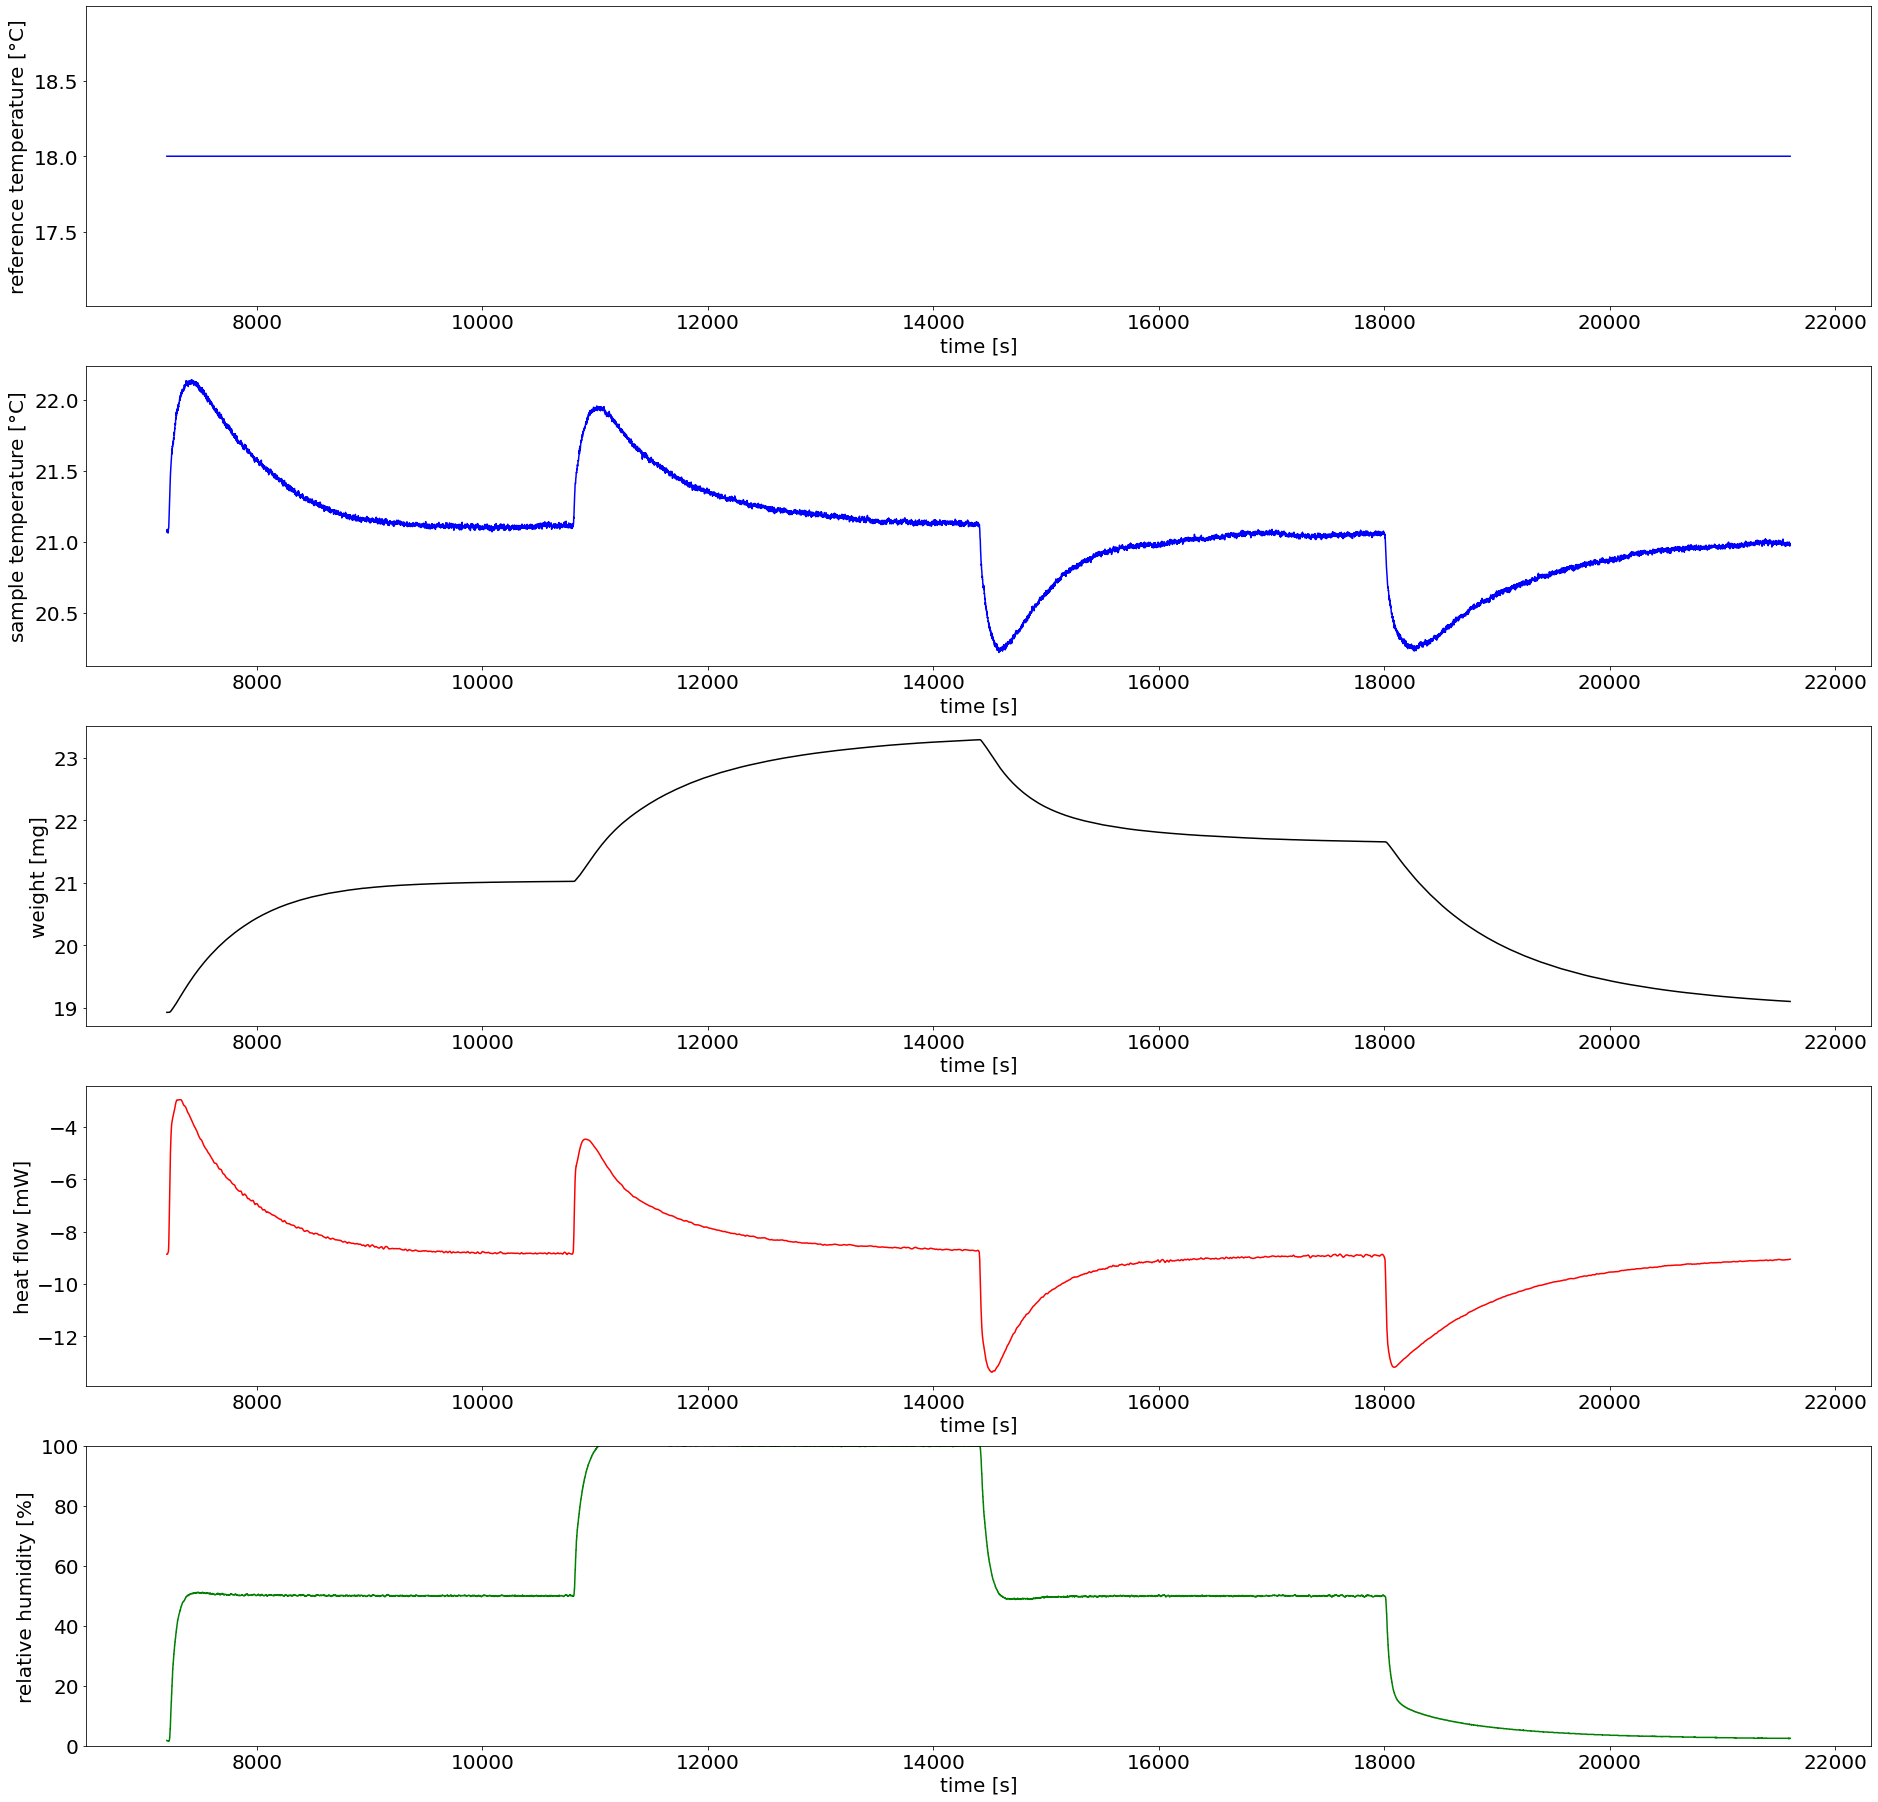

In [12]:
chgc_test.chgc_data()

In [13]:
chgc_test.data_fouriertransform()

/var/folders/yj/sjr_202x2fvfp9wq2lrrdf0h0000gn/T/ipykernel_20612/3616322077.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data_fft_power = self.data_fft_power.astype(d_type_d)


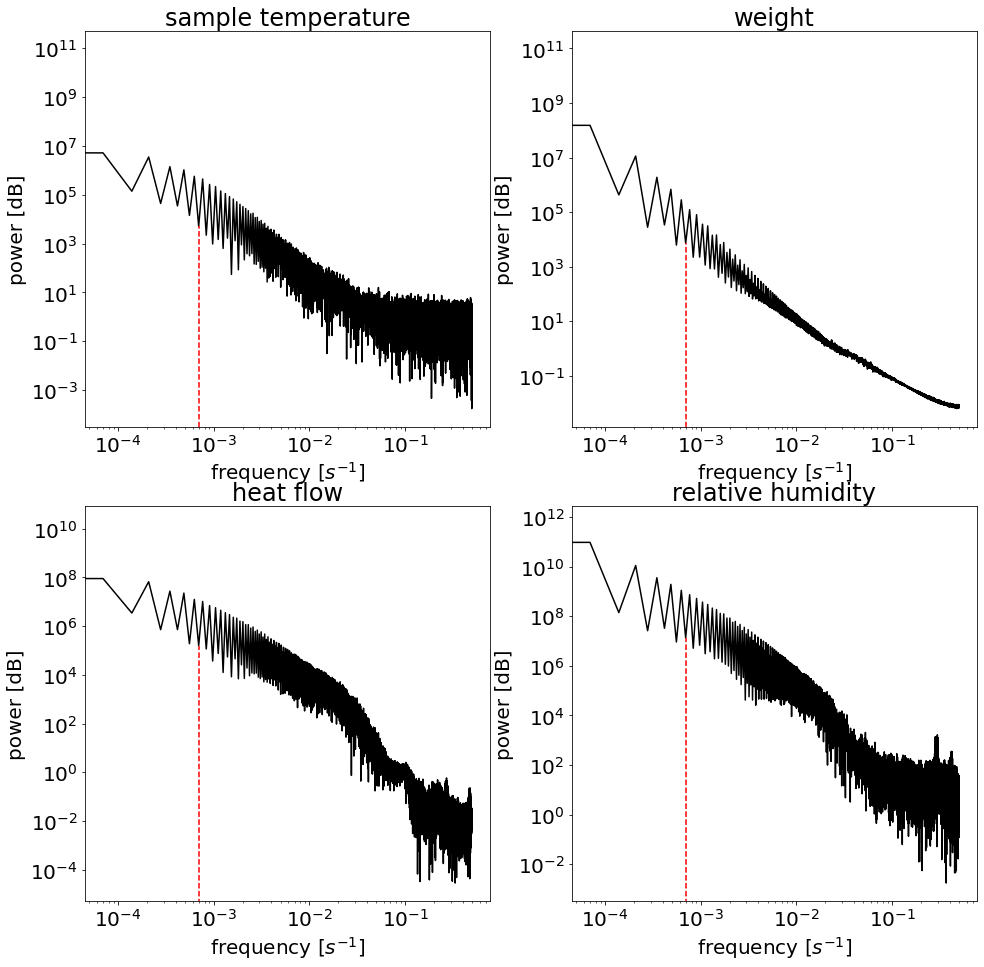

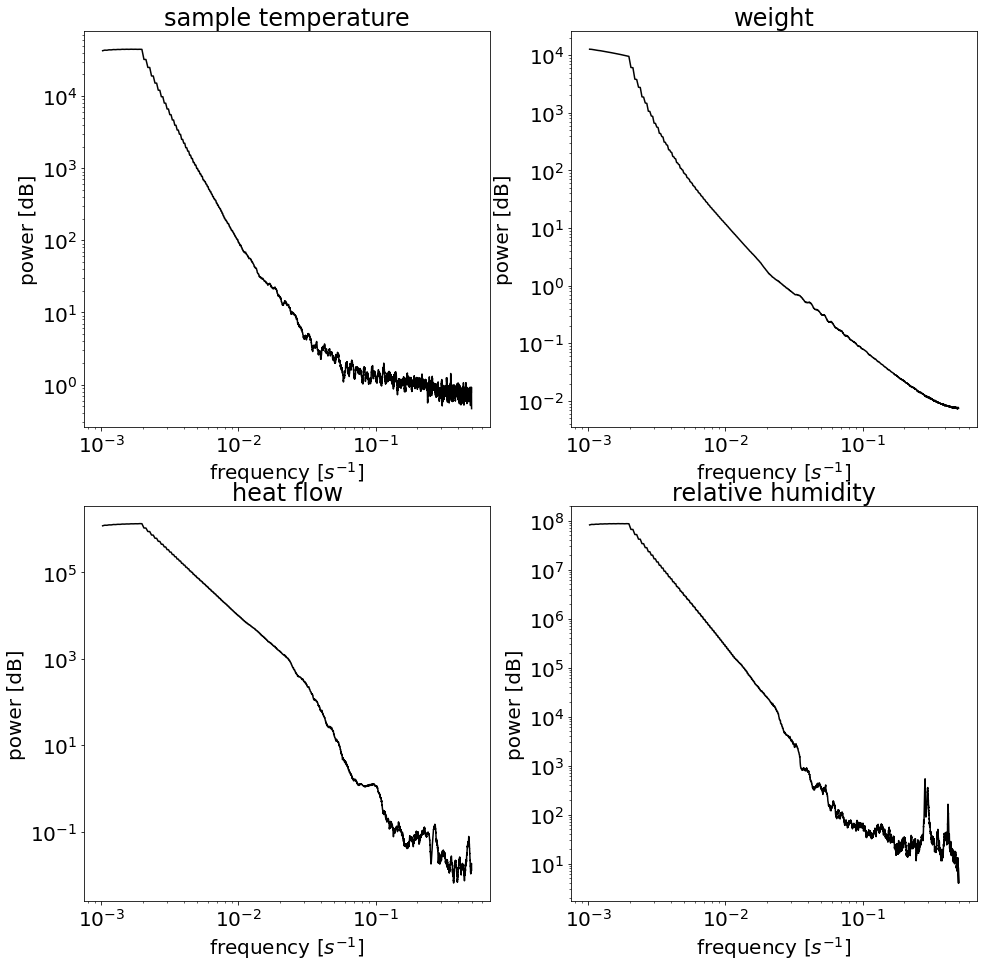

In [14]:
chgc_test.chgc_fft_data()

/Users/mwhittaker/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/mwhittaker/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/mwhittaker/opt/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


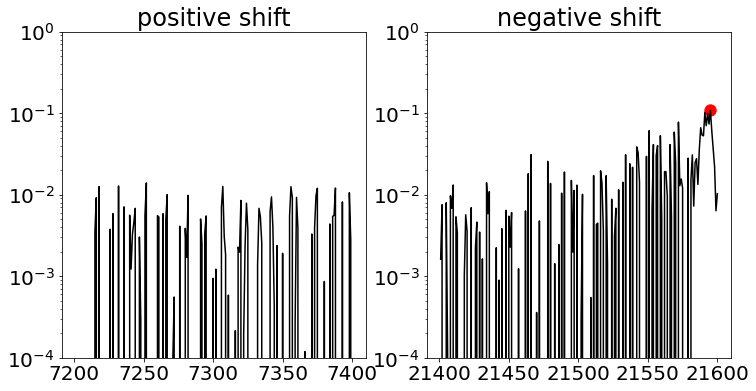

In [15]:
chgc_test.rh_lag()

/Users/mwhittaker/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/mwhittaker/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/mwhittaker/opt/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


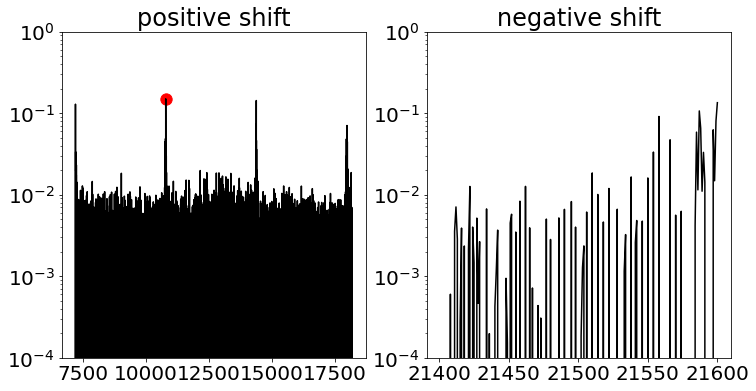

In [16]:
chgc_test.weight_lag()

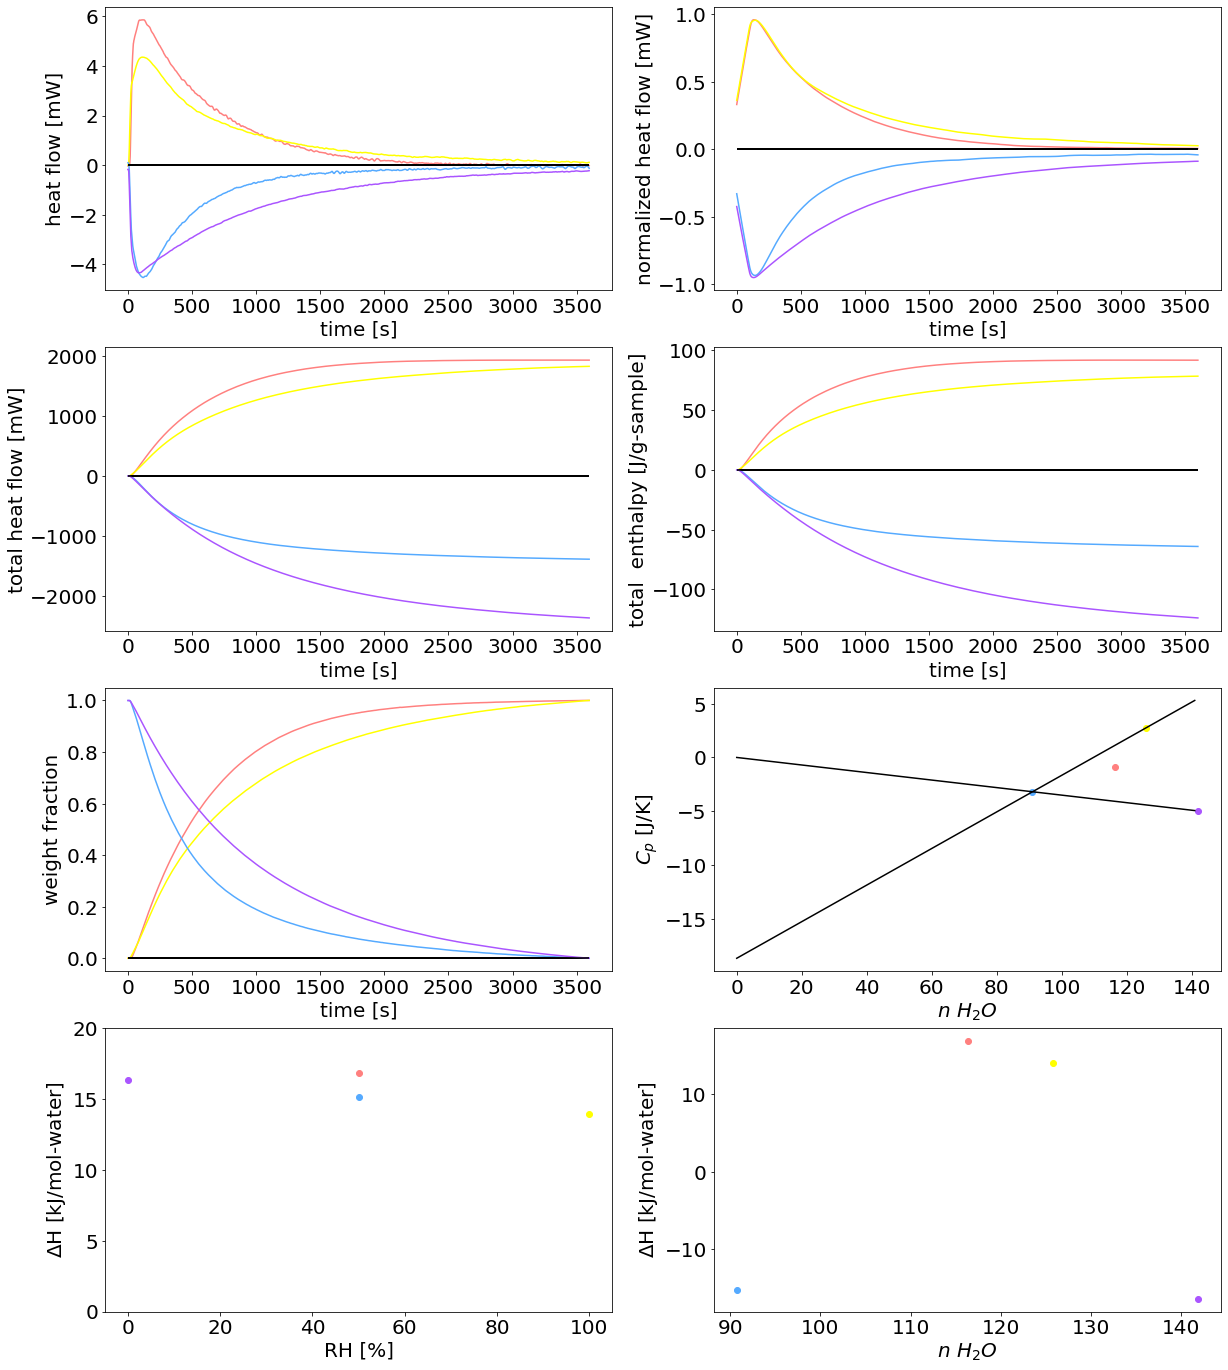

In [17]:
chgc_test.hydration_integrate()

In [18]:
np.mean(np.abs(chgc_test.enthalpies)), np.std(np.abs(chgc_test.enthalpies))

(15.544171995986268, 1.113825472372018)